<a href="https://colab.research.google.com/github/james-lucius/qureca_ADEQUATE/blob/main/M9_241_QNNs_2_4_Example_Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.com/qworld/qeducation/educational-materials/adequate-qbook1/raw/main/qworld/images/adq_1.png" align="left" width=450>

_prepared by Claudia Zendejas-Morales_

## 2.4 Example: Breast Cancer Classification

Let's look at a complete example in [PennyLane](https://pennylane.ai/), which is a flexible and powerful open-source framework for quantum programming, and it shines especially when working with quantum neural network models.

We will use it along with [TensorFlow](https://www.tensorflow.org/) to train a QNN to perform a binary classification.

We are going to use one of the toy datasets provided by the
scikit-learn package: the "[Breast cancer Wisconsin dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)." This dataset has $569$ samples with $30$ numerical features each that can be used to characterize whether a breast mass is benign or malignant. The label of each sample can be either $0$ or $1$, respectively.

Setting up the environment:

In [ ]:
!pip install pennylane==0.40.0 &> /dev/null   # use "&> /dev/null" so that the standard output of the installation is not displayed

!pip install silence-tensorflow &> /dev/null

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"       # to configure compatibility with PennyLane

from silence_tensorflow import silence_tensorflow
silence_tensorflow()                          # do not show annoying TensorFlow warnings

print("Setup completed")

Setup completed


Let's begin with some necessary imports and setting some seeds to make sure that our results are reproducible:

In [ ]:
import pennylane as qml
import numpy as np
import tensorflow as tf

seed = 4321
np.random.seed(seed)
tf.random.set_seed(seed)

tf.keras.backend.set_floatx('float64')  # ask TensorFlow to work with doubles just as PennyLane does

We load the dataset and separate the features and labels into two different variables:

In [ ]:
from sklearn.datasets import load_breast_cancer


bc_data = load_breast_cancer()

x = bc_data.data      # features
y = bc_data.target    # labels

Let's print the description of the dataset and see what is inside:

In [ ]:
print(bc_data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

We split our dataset into a training, validation, and test dataset:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

All the features in the dataset are non-zero, but they are not normalized. To use them with a feature map, we normalize them to be between $0$ and $1$:

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_test = np.clip(x_test, 0, 1)        # all values must be between 0 and 1
x_val = np.clip(x_val, 0, 1)

Now, let's consider the problem of our dataset having $30$ features, which is a rather large number. Although quantum hardware with this (or more) number of qubits already exists, we can explore other alternatives: use amplitude encoding with $5$ qubits, allowing us to accommodate $2^5=32$ features; or use some dimensionality reduction technique, such as [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).

By using principal component analysis, we can reduce the number of features to $4$, which will allow us to create our QNN with only $4$ qubits:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)                   # use the 4 principal features
xs_train = pca.fit_transform(x_train)
xs_val = pca.transform(x_val)
xs_test = pca.transform(x_test)

We'll use **angle encoding** for the feature map, which is implemented in PennyLane in the [qml.AngleEmbedding](https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html) class.

For the variational form, we'll use **two-local**. Since this isn't directly implemented in PennyLane, we'll create our own implementation using a linear entanglement chain, as described in section 2.1.2.

In [ ]:
def TwoLocal(n_qubits, theta, reps=1):

  for r in range(reps):

    for i in range(n_qubits):
      qml.RY(theta[r*n_qubits + i], wires=i)
    for i in range(n_qubits-1):
      qml.CNOT(wires=[i, i + 1])

  for i in range(n_qubits):
    qml.RY(theta[reps*n_qubits + i], wires=i)

Let's visualize the two-local implementation for the case of 4 qubits and 2 repetitions:

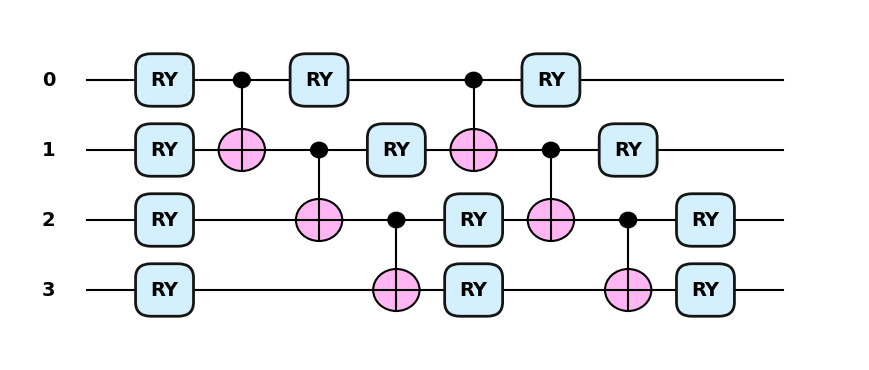

In [ ]:
fig, ax = qml.draw_mpl(TwoLocal, style='pennylane')(4, np.random.rand(12), 2)
fig.set_size_inches(8.5, 3.5)
fig.show()

PennyLane has a version of two-local with a circular entanglement chain in the [qml.BasicEntanglerLayers](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasicEntanglerLayers.html) class.

Now, let us remember that a _Hermitian operator_ can represent any physical observable, so all the possible outcomes of measuring the observable can be matched to the operator's different eigenvalues.

When we measure a single qubit in the computational basis, the matrix with respect to the computational basis of the associated Hermitian operator can be, for example, one of the following:

$$
M = \begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}, \quad\quad\quad\quad Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

Both of these operators represent the measurement of a qubit, but they differ in the eigenvalues that they associate with the distinct outputs. The first operator associates the eigenvalues $1$ and $0$ to the qubit's value being $0$ and $1$, respectively, while the second observable associates the eigenvalues $1$ and $-1$ to these outcomes.

PennyLane offers several [measurement possibilities](https://pennylane.ai/blog/2022/06/how-to-do-measurements-in-pennylane/) for our quantum circuits. For example, given a Hermitian matrix, we can obtain the expectation value for a set of qubits (wires) by calling `qml.expval()`; of course, the matrix dimension must be compatible with the number of qubits we wish to measure.

This is useful in our case; to obtain the expected value for the first qubit, we only need to create the matrix $M$. Using this Hermitian operator, we will get an output with a value between $0$ and $1$, which is perfect for a QNN, which is a classifier, assigning class $1$ to each sample with a value of $0.5$ or greater, and class $0$ to the rest.

In [ ]:
state0 = [[1], [0]]               # define state |0>

M = state0 * np.conj(state0).T    # create matrix M = |0><0|

Now we create our QNN as a quantum circuit, which we achieve by creating a function and annotating it with `qml.qnode`, which receives the argument `interface="tf"` to indicate that this quantum node will work with tensors, the TensorFlow data objects.

The function receives two arguments (`inputs` and `theta`), the first one is mandatory so that PennyLane can treat the qnode as a QNN with TensorFlow, and the name must be exactly `inputs`:

In [ ]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def qnn(inputs, theta):

  qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))     # encoding

  TwoLocal(n_qubits, theta, reps=3)                               # variational form

  return qml.expval(qml.Hermitian(M, wires=[0]))                  # measure qubit 0


Thanks to PennyLane's great interoperability, we can train our QNN with TensorFlow almost as if it were a classic one.

We create a Keras layer that contains our QNN, just as if it were a layer of a classic model:

In [ ]:
weights_dict = {"theta": 16}

qlayer = qml.qnn.KerasLayer(qnode=qnn,
                            weight_shapes=weights_dict,
                            output_dim=1)               # we obtain a single measurement from the QNN

Note that we must specify information about the shape of the tensor containing the weights (the parameters to be optimized); in our case, we are using two-local with $3$ repetitions, so we need $16$ elements in the vector $\boldsymbol{\theta}$ (this is how it is received in `TwoLocal`), $4$ for each repetition, plus $4$ that complete the variational form, refer to section 2.1.2.

Now let's create the Keras model:

In [ ]:
model = tf.keras.models.Sequential([qlayer])

We need to choose an optimizer and a loss function to compile the model, just like in a classic NN. We choose the [Adam](https://keras.io/api/optimizers/adam/) optimizer with a learning rate of $0.007$ and the [binary cross entropy loss](https://keras.io/api/losses/probabilistic_losses/), since we are training a binary classifier:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.007)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy())

The next step is to train the model, for which we call the `fit` method.

We configure an [early stopping](https://en.wikipedia.org/wiki/Early_stopping) regularization to avoid overfitting on the validation loss. With this, we can choose several epochs without many restrictions; we choose $150$. We configure a [batch size](https://www.geeksforgeeks.org/batch-size-in-neural-network/) of $35$, which in code is as follows:

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',         # quantity to be monitored
                                              patience=2,                 # number of epochs with no improvement after training stopped
                                              verbose=1,                  # display messages
                                              restore_best_weights=True)  # restore model weights from the epoch with the best value


# save history to be able to plot the training progress
history = model.fit(xs_train,                                             # use the data obtained after PCA
                    y_train,
                    epochs=150,
                    batch_size=35,
                    shuffle=True,
                    validation_data=(xs_val, y_val),
                    callbacks=[early_stop])

Epoch 1/150
4/4 [==============================] - 2s 468ms/step - loss: 0.7445 - val_loss: 0.6782
Epoch 2/150
4/4 [==============================] - 2s 431ms/step - loss: 0.7194 - val_loss: 0.6536
Epoch 3/150
4/4 [==============================] - 2s 436ms/step - loss: 0.6906 - val_loss: 0.6324
Epoch 4/150
4/4 [==============================] - 1s 418ms/step - loss: 0.6722 - val_loss: 0.6142
Epoch 5/150
4/4 [==============================] - 1s 414ms/step - loss: 0.6504 - val_loss: 0.6004
Epoch 6/150
4/4 [==============================] - 2s 640ms/step - loss: 0.6345 - val_loss: 0.5900
Epoch 7/150
4/4 [==============================] - 2s 549ms/step - loss: 0.6236 - val_loss: 0.5829
Epoch 8/150
4/4 [==============================] - 1s 404ms/step - loss: 0.6135 - val_loss: 0.5787
Epoch 9/150
4/4 [==============================] - 1s 412ms/step - loss: 0.6084 - val_loss: 0.5766
Epoch 10/150
4/4 [==============================] - 1s 417ms/step - loss: 0.6055 - val_loss: 0.5759
Epoch 11/

Remember that we discussed the different ways in which **gradients** involving QNNs could be computed. And you might wonder why we haven't had to deal with that to get our model trained.

It turns out that _PennyLane has already picked the best differentiation method for computing gradients_. Each quantum node can use specific differentiation methods; for example, nodes with devices that act as interfaces to real hardware can't use automatic differentiation methods, but nodes with simulators can, and most do.

Although we can observe the progress with the previous output, it's always helpful to have a plot that allows us to see the training process at a glance.

Let's also calculate the accuracy for each subset.

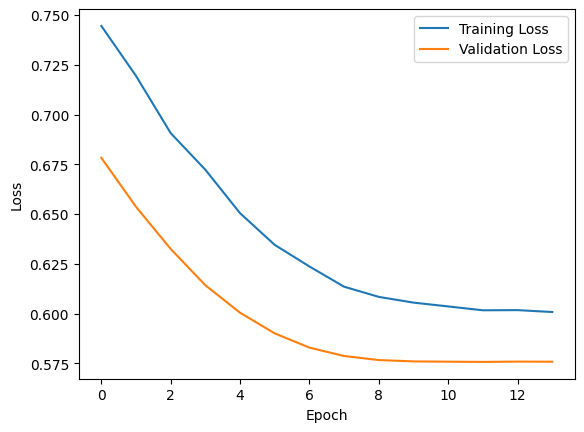

8/8 [==============================] - 1s 167ms/step
Train accuracy: 0.6814159292035398
Validation accuracy: 0.7236842105263158
Test accuracy: 0.6535087719298246


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


train_acc = accuracy_score(model.predict(xs_train) >= 0.5, y_train)
val_acc = accuracy_score(model.predict(xs_val) >= 0.5, y_val)
test_acc = accuracy_score(model.predict(xs_test) >= 0.5, y_test)

print(f"Train accuracy: {train_acc}")
print(f"Validation accuracy: {val_acc}")
print(f"Test accuracy: {test_acc}")

The model works, but it's not very good. We can start changing the hyperparameters to improve the accuracy, but before that, let's change the variational form. Let's now use **strongly entangling layers**. Instead of creating our implementation, let's use the one provided by PennyLane ([qml.StronglyEntanglingLayers](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)).

In [ ]:
@qml.qnode(dev, interface="tf")
def qnn2(inputs, theta):

  qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
  qml.StronglyEntanglingLayers(theta, wires=range(n_qubits))

  return qml.expval(qml.Hermitian(M, wires=[0]))

We create the Keras layer as before.

Notice that the dictionary specifying the dimension of $\boldsymbol{\theta}$ has changed. We now specify three numbers, just as the `qml.StronglyEntanglingLayers` class expects. The first indicates the number of layers we want in our variational form ($3$ in this example), the second indicates the number of qubits, and the third indicates the number of parameters per qubit.

In [ ]:
weights_dict2 = {"theta": (3, n_qubits, 3)}

qlayer2 = qml.qnn.KerasLayer(qnode=qnn2,
                             weight_shapes=weights_dict2,
                             output_dim=1)

We create a new model, compile it, and train it with the same options as before:

In [ ]:
model2 = tf.keras.models.Sequential([qlayer2])

opt2 = tf.keras.optimizers.Adam(learning_rate=0.007)          # we use the same optimizer (a new instance must be created)
model2.compile(optimizer=opt2,
               loss=tf.keras.losses.BinaryCrossentropy())     # we use the same loss function

history2 = model2.fit(xs_train,                               # use the data obtained after PCA
                      y_train,
                      epochs=150,                             # we use the same number of epochs
                      batch_size=35,                          # we use the same batch size
                      shuffle=True,
                      validation_data=(xs_val, y_val),
                      callbacks=[early_stop])                 # we use the same early stopping

Epoch 1/150
4/4 [==============================] - 6s 2s/step - loss: 0.8221 - val_loss: 0.8103
Epoch 2/150
4/4 [==============================] - 2s 542ms/step - loss: 0.7747 - val_loss: 0.7621
Epoch 3/150
4/4 [==============================] - 2s 547ms/step - loss: 0.7240 - val_loss: 0.7178
Epoch 4/150
4/4 [==============================] - 2s 731ms/step - loss: 0.6864 - val_loss: 0.6751
Epoch 5/150
4/4 [==============================] - 3s 814ms/step - loss: 0.6445 - val_loss: 0.6369
Epoch 6/150
4/4 [==============================] - 5s 1s/step - loss: 0.6090 - val_loss: 0.6039
Epoch 7/150
4/4 [==============================] - 8s 2s/step - loss: 0.5828 - val_loss: 0.5751
Epoch 8/150
4/4 [==============================] - 5s 1s/step - loss: 0.5560 - val_loss: 0.5525
Epoch 9/150
4/4 [==============================] - 5s 1s/step - loss: 0.5377 - val_loss: 0.5344
Epoch 10/150
4/4 [==============================] - 6s 2s/step - loss: 0.5223 - val_loss: 0.5198
Epoch 11/150
4/4 [=========

Let's review the training progress and accuracies:

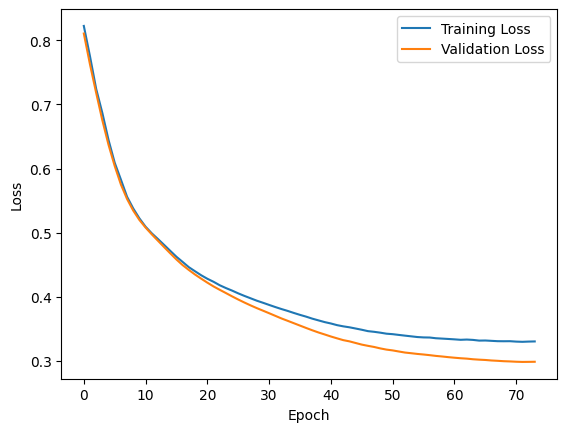

8/8 [==============================] - 1s 101ms/step
Train accuracy: 0.9026548672566371
Validation accuracy: 0.8859649122807017
Test accuracy: 0.8991228070175439


In [ ]:
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


train_acc2 = accuracy_score(model2.predict(xs_train) >= 0.5, y_train)
val_acc2 = accuracy_score(model2.predict(xs_val) >= 0.5, y_val)
test_acc2 = accuracy_score(model2.predict(xs_test) >= 0.5, y_test)

print(f"Train accuracy: {train_acc2}")
print(f"Validation accuracy: {val_acc2}")
print(f"Test accuracy: {test_acc2}")

This second model is better, as its accuracy has improved considerably.

Even better results can be achieved by changing the encoding, variational form, optimizer, and hyperparameters (early stopping settings, batch size, etc.).

We could also consider using more qubits, depending on the encoding, as well as considering more components in the PCA or not using PCA and using the $30$ features from the original dataset. Here is where the art of adjusting a QNN model comes in, just like the classical counterpart.

On the other hand, we could also modify the **differentiation method**, which would give us different results. We mentioned above that PennyLane uses the "best" method by default, but we can explicitly specify one. This is achieved when defining the _qnode_:

```python
@qml.qnode(dev, interface="tf", diff_method="method")  # default set to "best"

```

To learn more about the various optimizers and differentiation methods that can be used in PennyLane, visit this [link](https://docs.pennylane.ai/en/stable/introduction/interfaces.html).